In [1]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import os
import gzip
import numpy as np
import scanpy as sc
import squidpy as sq
import cupy as cp
import cupyx
from cupyx.scipy.sparse import csr_matrix 
import os
import time
import rapids_singlecell as rsc
import numpy as np
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
import cupy

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=False,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)
import zarr
import pickle
from collections import OrderedDict
from scipy.sparse import csr_matrix
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
from scipy.sparse import csr_matrix
import scipy
import anndata
from collections import OrderedDict
from rsc_functions.utility.applyqc import applyqc
from rsc_functions.reports.plot import plot_spatial,plot_spatial_data, plot_dist
from rsc_functions.utility.rank_genes_groups import return_markers,rank_genes_groups
from rsc_functions.reports.plot import plot_expression

In [2]:
path_016 = "/data/kanferg/Sptial_Omics/playGround/Data/Visium_HD_Human_Colon_Cancer_binned_outputs/binned_outputs/square_016um"
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out_2"

In [3]:
def parquet_to_csv(path):
    '''
    Converts a Parquet file to a CSV file if the CSV file does not already exist.
    '''
    file_path = os.path.join(path,'spatial/tissue_positions_list.csv')
    if not os.path.exists(file_path):
        df = pd.read_parquet(os.path.join(path,'spatial/tissue_positions.parquet'))
        # Write to a CSV file
        df.to_csv(os.path.join(path,'spatial/tissue_positions_list.csv'), index=False)
    return
parquet_to_csv(path_016)

In [4]:
andata = sc.read_visium(path=path_016)
rsc.get.anndata_to_GPU(andata)
andata.obsm['spatial'] = np.array(andata.obsm['spatial'], dtype=np.float64)
andata.var_names_make_unique()
andata.uns['config'] = OrderedDict()
andata.uns["config"]["secondary_var_names"] = andata.var_names
rsc.pp.flag_gene_family(andata, gene_family_name="MT", gene_family_prefix="MT-")
rsc.pp.calculate_qc_metrics(andata, qc_vars=["MT"])

/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/readwrite.py:476: DtypeWarning: Columns (1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  positions = pd.read_csv(


In [5]:
andata

AnnData object with n_obs × n_vars = 137051 × 18085
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts'
    uns: 'spatial', 'config'
    obsm: 'spatial'

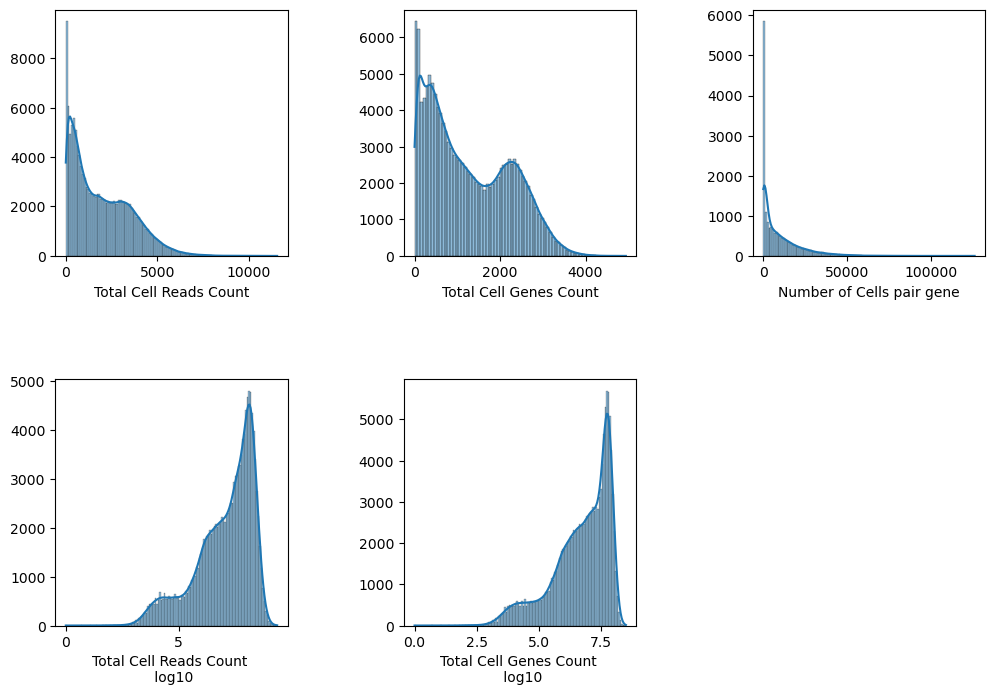

In [6]:
import warnings
# Suppress warnings in this specific code chunk
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig, ax = plt.subplots(2, 3, figsize=(12, 8))
    ax = np.ravel(ax)
    plot_dist(andata,column = 'total_counts',ax = ax[0],xlab = 'Total Cell Reads Count')
    plot_dist(andata,column = 'n_genes_by_counts',ax = ax[1],xlab = 'Total Cell Genes Count')
    plot_dist(andata,column = 'n_cells_by_counts',bins = 'doane', type = 'var', ax = ax[2],xlab = 'Number of Cells pair gene')
    plot_dist(andata,column = 'log1p_total_counts',ax = ax[3],xlab = 'Total Cell Reads Count \n log10')
    plot_dist(andata,column = 'log1p_n_genes_by_counts',ax = ax[4],xlab = 'Total Cell Genes Count \n log10')
    ax[5].axis('off')
    plt.subplots_adjust(wspace = 0.5, hspace=0.5)

In [7]:
plt.rcParams['figure.dpi'] = 600
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
fig, ax = plt.subplots(1,1, figsize=(15, 15))
with PdfPages(os.path.join(pathout, 'Report_spatial_map_plot_Colon_total_count.pdf')) as pdf:
    plot_spatial_data(andata, 'total_counts', fig = fig , ax = ax ,set_xlabel_cbar = 'Total Count',size = 1)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
    pdf.savefig()
    plt.close()   

In [9]:
rsc.pp.filter_cells(andata, min_count=50,qc_var = 'total_counts')
rsc.pp.filter_genes(andata, min_count=50)
rsc.pp.filter_genes(andata, max_count=50_000)
andata.layers['counts'] = andata.X.copy()
rsc.pp.normalize_total(andata)
rsc.pp.log1p(andata)
andata.layers['log'] = andata.X.copy()
rsc.pp.highly_variable_genes(andata, n_top_genes=1500, flavor="seurat_v3", layer="log")
andata = andata[:, andata.var["highly_variable"]]
rsc.pp.scale(andata, max_value=10)
rsc.pp.pca(andata, n_comps=30,random_state=1337, use_highly_variable=False)

filtered out 3769 cells
filtered out 1143 genes based on n_cells_by_counts
filtered out 253 genes based on n_cells_by_counts


/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/rapids_singlecell/preprocessing/_hvg.py:517: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/rapids_singlecell/preprocessing/_scale.py:71: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


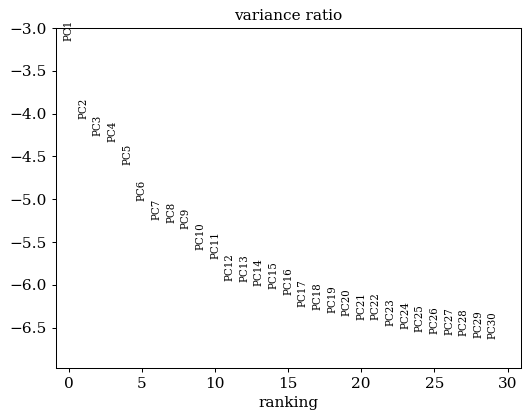

In [10]:
sc.pl.pca_variance_ratio(andata, log=True, n_pcs=30)

In [11]:
rsc.pp.neighbors(andata, n_pcs=15, use_rep='X_pca', n_neighbors=25)
rsc.tl.leiden(andata, random_state=1337, resolution=0.5, key_added='cluster') 

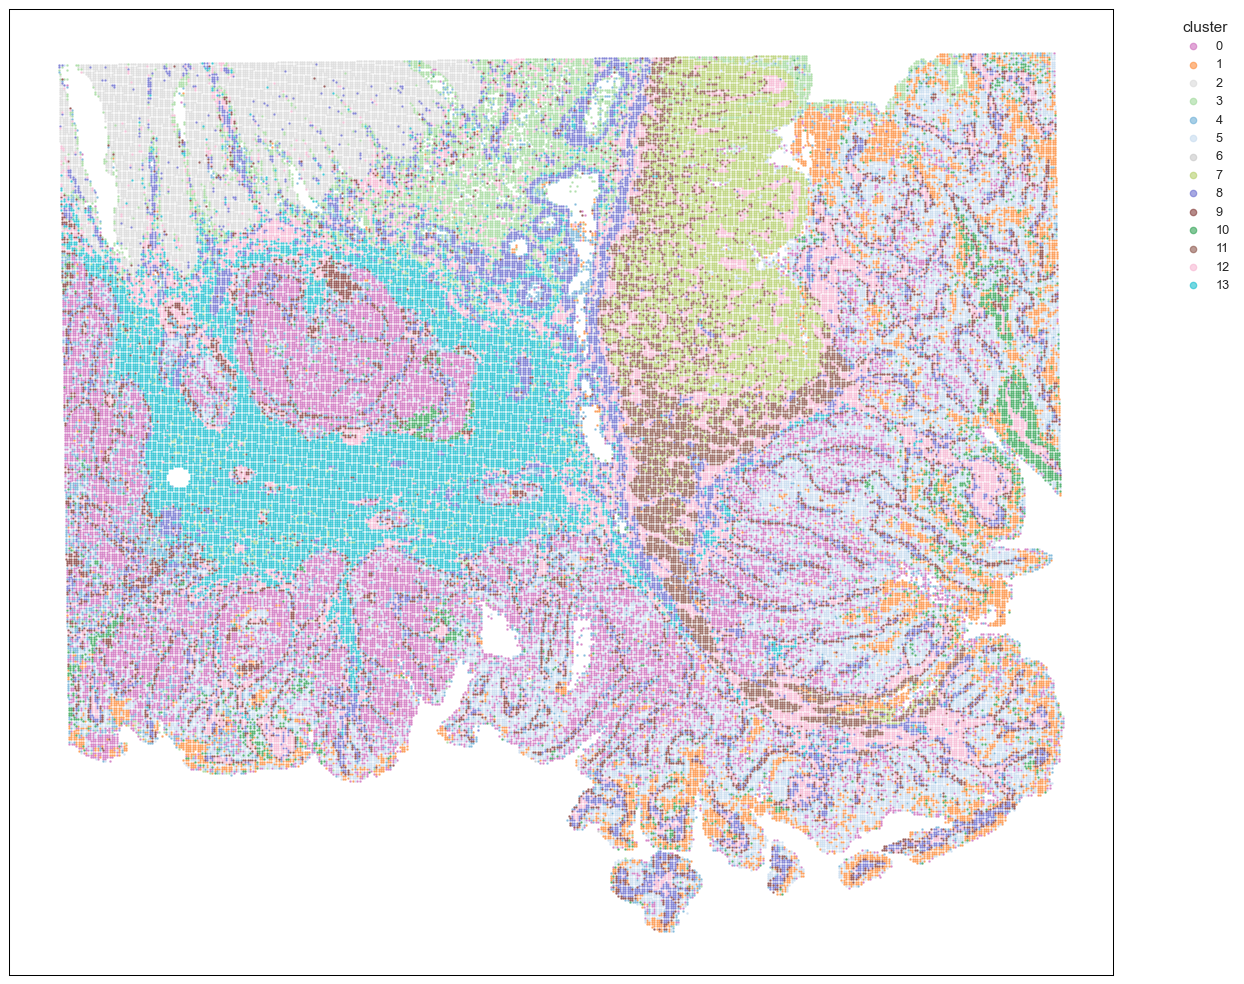

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
plt.rcParams['figure.dpi'] = 800
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
clusterColorMap = plot_spatial(andata,ax = ax, features = None, title = '',markerscale = 5, xlab = '',ylab ='',size = 1,random_palette = True)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)

In [13]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages(os.path.join(pathout, 'Report_spatial_map_plot_Colon.pdf')) as pdf:
    fig, ax = plt.subplots(1, 1, figsize=(15,15))
    plt.rcParams['figure.dpi'] = 800
    plt.rcParams['font.family'] = ['serif']
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    clusterColorMap = plot_spatial(andata,ax = ax, features = None, title = '',markerscale = 5, xlab = '',ylab ='',size = 1,random_palette = True)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
    pdf.savefig()
    plt.close()

In [14]:
andata.uns['clusterColorMap'] = clusterColorMap

In [15]:
rsc.get.anndata_to_CPU(andata)
sc.tl.rank_genes_groups(andata, groupby="cluster", method="wilcoxon")

/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_sing

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
sc.pl.rank_genes_groups_dotplot(andata, groupby="cluster",n_genes=2,values_to_plot = 'scores',ax =ax)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)

<Figure size 1920x1440 with 0 Axes>

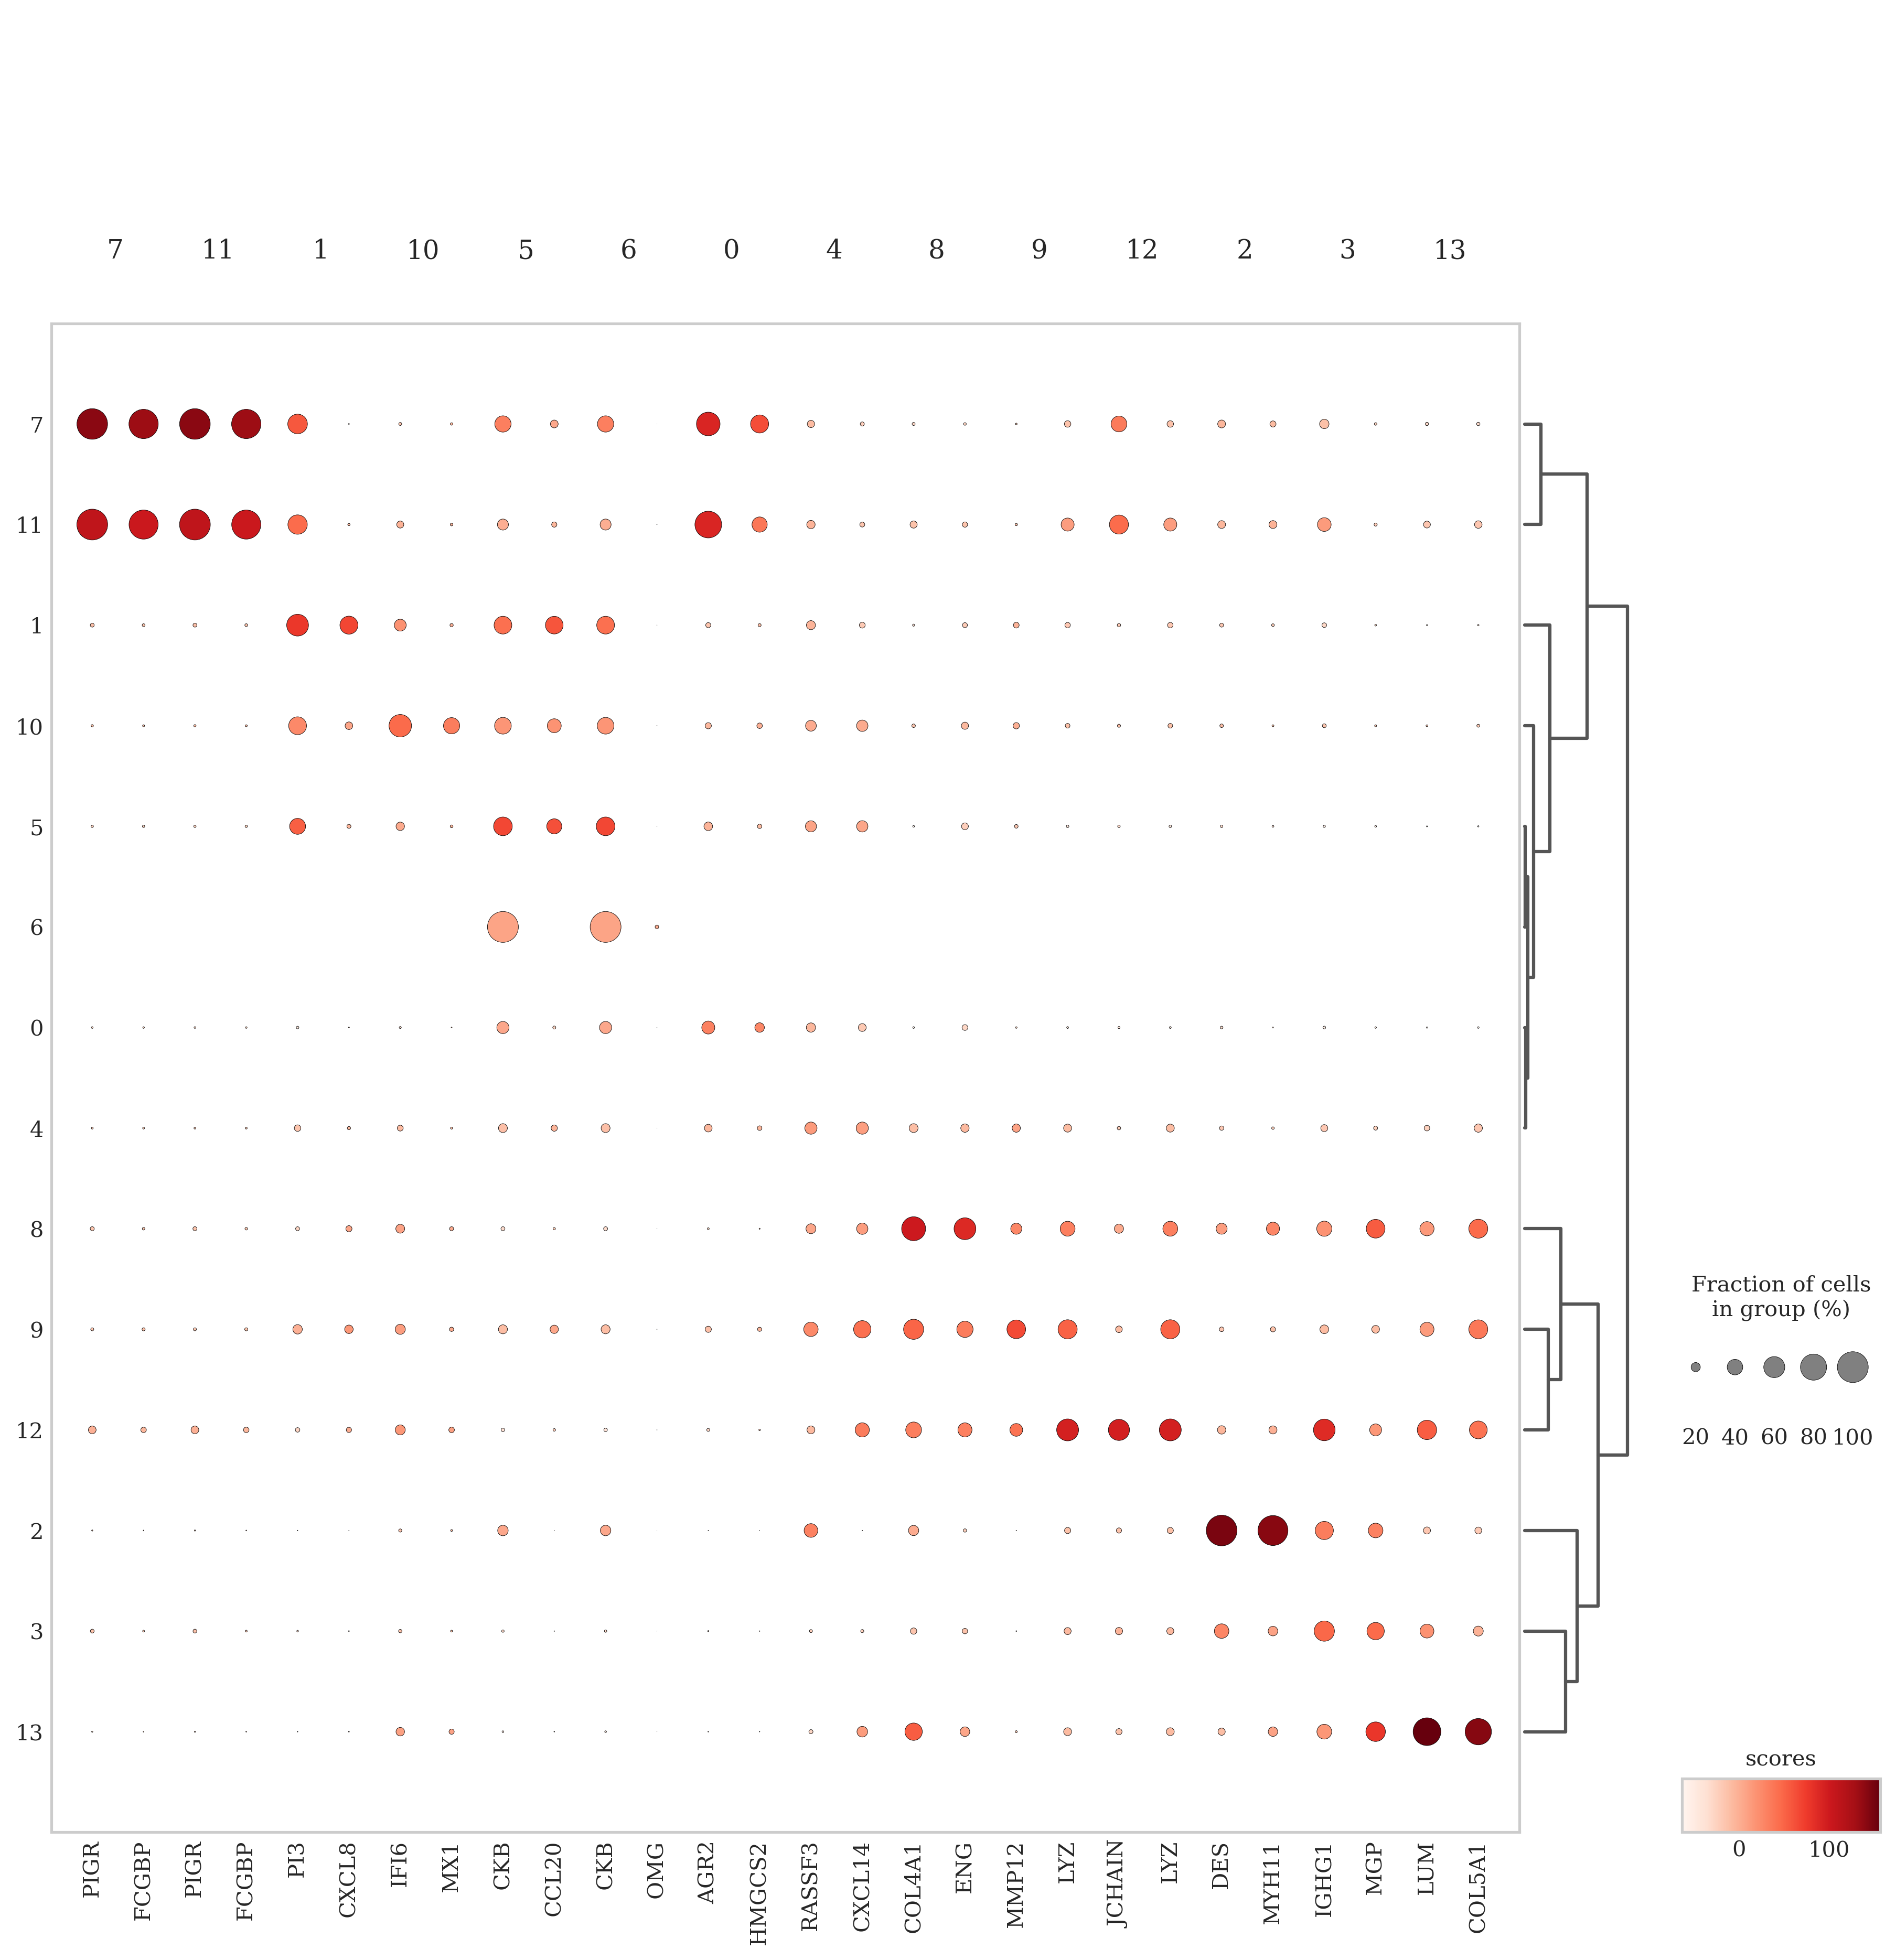

In [17]:
with PdfPages(os.path.join(pathout, 'dendrogram_colon.pdf')) as pdf:
    fig, ax = plt.subplots(1, 1, figsize=(15,15))
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['font.family'] = ['serif']
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    sc.pl.rank_genes_groups_dotplot(andata, groupby="cluster",n_genes=2,values_to_plot = 'scores',ax =ax)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
    pdf.savefig()
    plt.close()

In [18]:
import squidpy as sq
sq.gr.spatial_neighbors(andata, coord_type="generic",delaunay = True)
sq.gr.nhood_enrichment(andata, cluster_key="cluster")

/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 96.63/s]


In [19]:
from matplotlib.colors import LinearSegmentedColormap
with PdfPages(os.path.join(pathout, 'nhood_enrichment_colon.pdf')) as pdf:
    colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # Blue -> White -> Red
    n_bins = 100  # Discretize into 100 bins
    custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=n_bins)
    
    plt.rcParams['figure.dpi'] = 92
    plt.rcParams['font.family'] = ['serif']
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    
    sq.pl.nhood_enrichment(
        andata,
        title = "Neighborhood Enrichment generic",
        cluster_key="cluster",
        method="average",
        cmap=custom_cmap,
        vmin=-200,
        vmax=200,
        figsize=(5, 5),
    )
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
    pdf.savefig()
    plt.close()

/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/squidpy/pl/_utils.py:555: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]
/tmp/ipykernel_3744215/952633860.py:25: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)


In [20]:
from cupyx.scipy.sparse import csr_matrix
def save_matrix(matrix,pathout,file_name = "obsp_distances_large.npz"):
    cp.savez(os.path.join(pathout, file_name),  
            data=matrix.data,  
            indices=matrix.indices,  
            indptr=matrix.indptr,  
            shape=matrix.shape)
sparse_matrix = andata.obsp['distances']
save_matrix(matrix = sparse_matrix,pathout = pathout,file_name = "obsp_distances_large_colon.npz")
sparse_matrix = andata.obsp['connectivities']
save_matrix(matrix = sparse_matrix,pathout = pathout,file_name = "obsp_connectivities_large_colon.npz")

In [21]:
import pickle
with open(os.path.join(pathout,"andata_uns_mtracies__colon.pkl"), 'wb') as buff:
     pickle.dump({'config':andata.uns['config'], 'rank_genes_groups':andata.uns['rank_genes_groups'], 'clusterColorMap':andata.uns['clusterColorMap']}, buff)

In [22]:
andata

AnnData object with n_obs × n_vars = 133282 × 1500
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'config', 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'clusterColorMap', 'rank_genes_groups', 'dendrogram_cluster', 'spatial_neighbors', 'cluster_nhood_enrichment'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'log'
    obsp: 'distances', 'connectivities', 'spatial_connectivities', 'spatial_distances'

In [23]:
andata_save = andata.copy()
for column in andata_save.obs.columns:
    print(f"Column '{column}' has data type: {andata_save.obs[column].dtype}")

Column 'in_tissue' has data type: object
Column 'array_row' has data type: object
Column 'array_col' has data type: object
Column 'n_genes_by_counts' has data type: int32
Column 'total_counts' has data type: float32
Column 'log1p_n_genes_by_counts' has data type: float64
Column 'log1p_total_counts' has data type: float32
Column 'total_counts_MT' has data type: float32
Column 'pct_counts_MT' has data type: float32
Column 'log1p_total_counts_MT' has data type: float32
Column 'cluster' has data type: category


In [24]:
andata_save = andata.copy()
# andata_save.X = andata_save.layers['log']
del andata_save.uns
# del andata_save.obsm
del andata_save.varm
# del andata_save.layers
del andata_save.obsp
del andata_save.obs['in_tissue']
del andata_save.obs['array_row']
del andata_save.obs['array_col']
andata_save.write_h5ad(os.path.join(pathout, "andata_save_colon.h5ad"))

<center>stlearn

In [1]:
import cupy as cp
import cupyx
import scanpy as sc
import stlearn as st
import scanpy as sc
import numpy as np
from cupyx.scipy.sparse import csr_matrix
import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import random
import pandas as pd

/gpfs/gsfs10/users/kanferg/conda/envs/stlearn-env/lib/python3.8/site-packages/stlearn/tools/microenv/cci/het.py:192: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True, nopython=False)


In [2]:
path_016 = "/data/kanferg/Sptial_Omics/playGround/Data/Visium_HD_Human_Colon_Cancer_binned_outputs/binned_outputs/square_016um"
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out_2"
andata = sc.read_h5ad(os.path.join(pathout, "andata_save_colon.h5ad"))
def load_matrix(andata,pathout,npz_file = "obsp_distances.npz",mode = 'sparse', mat_name = 'distances'):
    npzfile = cp.load(os.path.join(pathout, npz_file))
    data = cp.array(npzfile['data'])
    indices = cp.array(npzfile['indices'])
    indptr = cp.array(npzfile['indptr'])
    shape = tuple(npzfile['shape'])
    
    # Reconstruct the sparse matrix
    sparse_matrix_distances = csr_matrix((data, indices, indptr), shape=shape)
    if mode== 'sparse':
        andata.obsp[mat_name] = sparse_matrix_distances
    else:
        andata.obsp[mat_name] = sparse_matrix_distances.get()
    return andata

In [3]:
andata.obs["imagerow"] = andata.obsm['spatial'][:,0]
andata.obs["imagecol"] = andata.obsm['spatial'][:,1]
andata.uns["spatial"] = andata.obsm["spatial"]
def make_uns_spatial(adata):
    #max_size = np.max([adata.obs["imagerow"].max(), adata.obs["imagecol"].max()])
    #max_size = int(max_size + 0.1 * max_size)
    #image = Image.new("RGBA", (max_size, max_size), (255, 255, 255, 255))
    #imgarr = np.array(image)
    adata.uns["spatial"] = {}
    adata.uns["spatial"]["id1"] = {}
    #adata.uns["spatial"]["id1"]["images"] = {}
    #adata.uns["spatial"]["id1"]["images"]["lowres"] = imgarr
    adata.uns["spatial"]["id1"]["use_quality"] = "lowres"
    adata.uns["spatial"]["id1"]["scalefactors"] = {}
    adata.uns["spatial"]["id1"]["scalefactors"]["tissue_low_scalef" ] = 1
    adata.uns["spatial"]["id1"]["scalefactors"]["spot_diameter_fullres"] = 15
    adata.uns["spatial"]["id1"]["scalefactors"][
            "tissue_" + "lowres" + "_scalef"
        ] = 1
    return adata
andata = make_uns_spatial(andata)

In [4]:
andata = load_matrix(andata,pathout,npz_file = "obsp_distances_large_colon.npz",mode = 'sparse', mat_name = 'distances')
andata = load_matrix(andata,pathout,npz_file = "obsp_connectivities_large_colon.npz",mode = 'sparse', mat_name = 'connectivities')

In [5]:
import os
import pickle

file_path = os.path.join(pathout, "andata_uns_mtracies__colon.pkl")

if os.path.getsize(file_path) > 0:
    with open(file_path, 'rb') as buff:
        andata_uns_mtracies = pickle.load(buff)
else:
    print("File is empty. Cannot load data.")
    andata_uns_mtracies = None
andata.uns["spatial"] = andata.obsm["spatial"]
andata.uns['clusterColorMap'] = andata_uns_mtracies['clusterColorMap']
andata.obs["imagerow"] = andata.obsm['spatial'][:,0]
andata.obs["imagecol"] = andata.obsm['spatial'][:,1]
andata.uns["spatial"] = andata.obsm["spatial"]

In [6]:
andata

AnnData object with n_obs × n_vars = 133282 × 1500
    obs: 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'cluster', 'imagerow', 'imagecol'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'clusterColorMap'
    obsm: 'X_pca', 'spatial'
    layers: 'counts', 'log'
    obsp: 'distances', 'connectivities'

In [7]:
andata.X =andata.layers['counts'].copy()

In [8]:
# Loading the LR databases available within stlearn (from NATMI)
lrs = st.tl.cci.load_lrs(['connectomeDB2020_lit'], species='human')
print(len(lrs))

2293


In [9]:
st.tl.cci.run(andata, lrs,
                  min_spots = 20, #Filter out any LR pairs with no scores for less than min_spots
                  distance=0, # None defaults to spot+immediate neighbours; distance=0 for within-spot mode
                  n_pairs=10000, # Number of random pairs to generate; low as example, recommend ~10,000
                  n_cpus=None, # Number of CPUs for parallel. If None, detects & use all available.
                  )

Calculating neighbours...
0 spots with no neighbours, 1 median spot neighbours.
Spot neighbour indices stored in adata.obsm['spot_neighbours'] & adata.obsm['spot_neigh_bcs'].
Altogether 184 valid L-R pairs


Generating backgrounds & testing each LR pair...: 100%|███████████████████████████████████████████████ [ time left: 00:00 ]



Storing results:

lr_scores stored in adata.obsm['lr_scores'].
p_vals stored in adata.obsm['p_vals'].
p_adjs stored in adata.obsm['p_adjs'].
-log10(p_adjs) stored in adata.obsm['-log10(p_adjs)'].
lr_sig_scores stored in adata.obsm['lr_sig_scores'].

Per-spot results in adata.obsm have columns in same order as rows in adata.uns['lr_summary'].
Summary of LR results in adata.uns['lr_summary'].


In [10]:
andata.uns['lr_summary']

n_spots  n_spots_sig  n_spots_sig_pval
MCAM_MCAM       12299        10141             10771
MUC2_AGR2        8426         8373              8387
COL4A1_ITGA1     9004         7516              8041
PTPRM_PTPRM      6339         5916              6311
CCN2_LRP1        7308         5698              6168
...               ...          ...               ...
ANGPTL1_TEK        26           26                26
IL16_KCNJ15        26           26                26
VWF_ITGA2B         24           24                24
NTRK3_PTPRS        21           21                21
CXCL5_CXCR2        21           21                21

[184 rows x 3 columns]

In [12]:
andata

AnnData object with n_obs × n_vars = 133282 × 1500
    obs: 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'cluster', 'imagerow', 'imagecol'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'clusterColorMap', 'lrfeatures', 'lr_summary'
    obsm: 'X_pca', 'spatial', 'spot_neighbours', 'spot_neigh_bcs', 'lr_scores', 'p_vals', 'p_adjs', '-log10(p_adjs)', 'lr_sig_scores'
    layers: 'counts', 'log'
    obsp: 'distances', 'connectivities'

In [13]:
import pickle
with open(os.path.join(pathout,"stlearn_uns_mtracies_colon.pkl"), 'wb') as buff:
     pickle.dump({'lrfeatures':andata.uns['lrfeatures'], 'lr_summary':andata.uns['lr_summary']}, buff)

In [19]:
andata.obsm['lr_scores'].shape

(133282, 184)

In [15]:
import pickle
with open(os.path.join(pathout,"stlearn_obsm_mtracies_colon.pkl"), 'wb') as buff:
     pickle.dump({'spot_neighbours':andata.obsm['spot_neighbours'], 'spot_neigh_bcs':andata.obsm['spot_neigh_bcs'],
                 'lr_scores':andata.obsm['lr_scores'], 'p_vals':andata.obsm['p_vals'],
                  '-log10(p_adjs)':andata.obsm['-log10(p_adjs)'], 'lr_sig_scores':andata.obsm['lr_sig_scores']
                 }, buff)

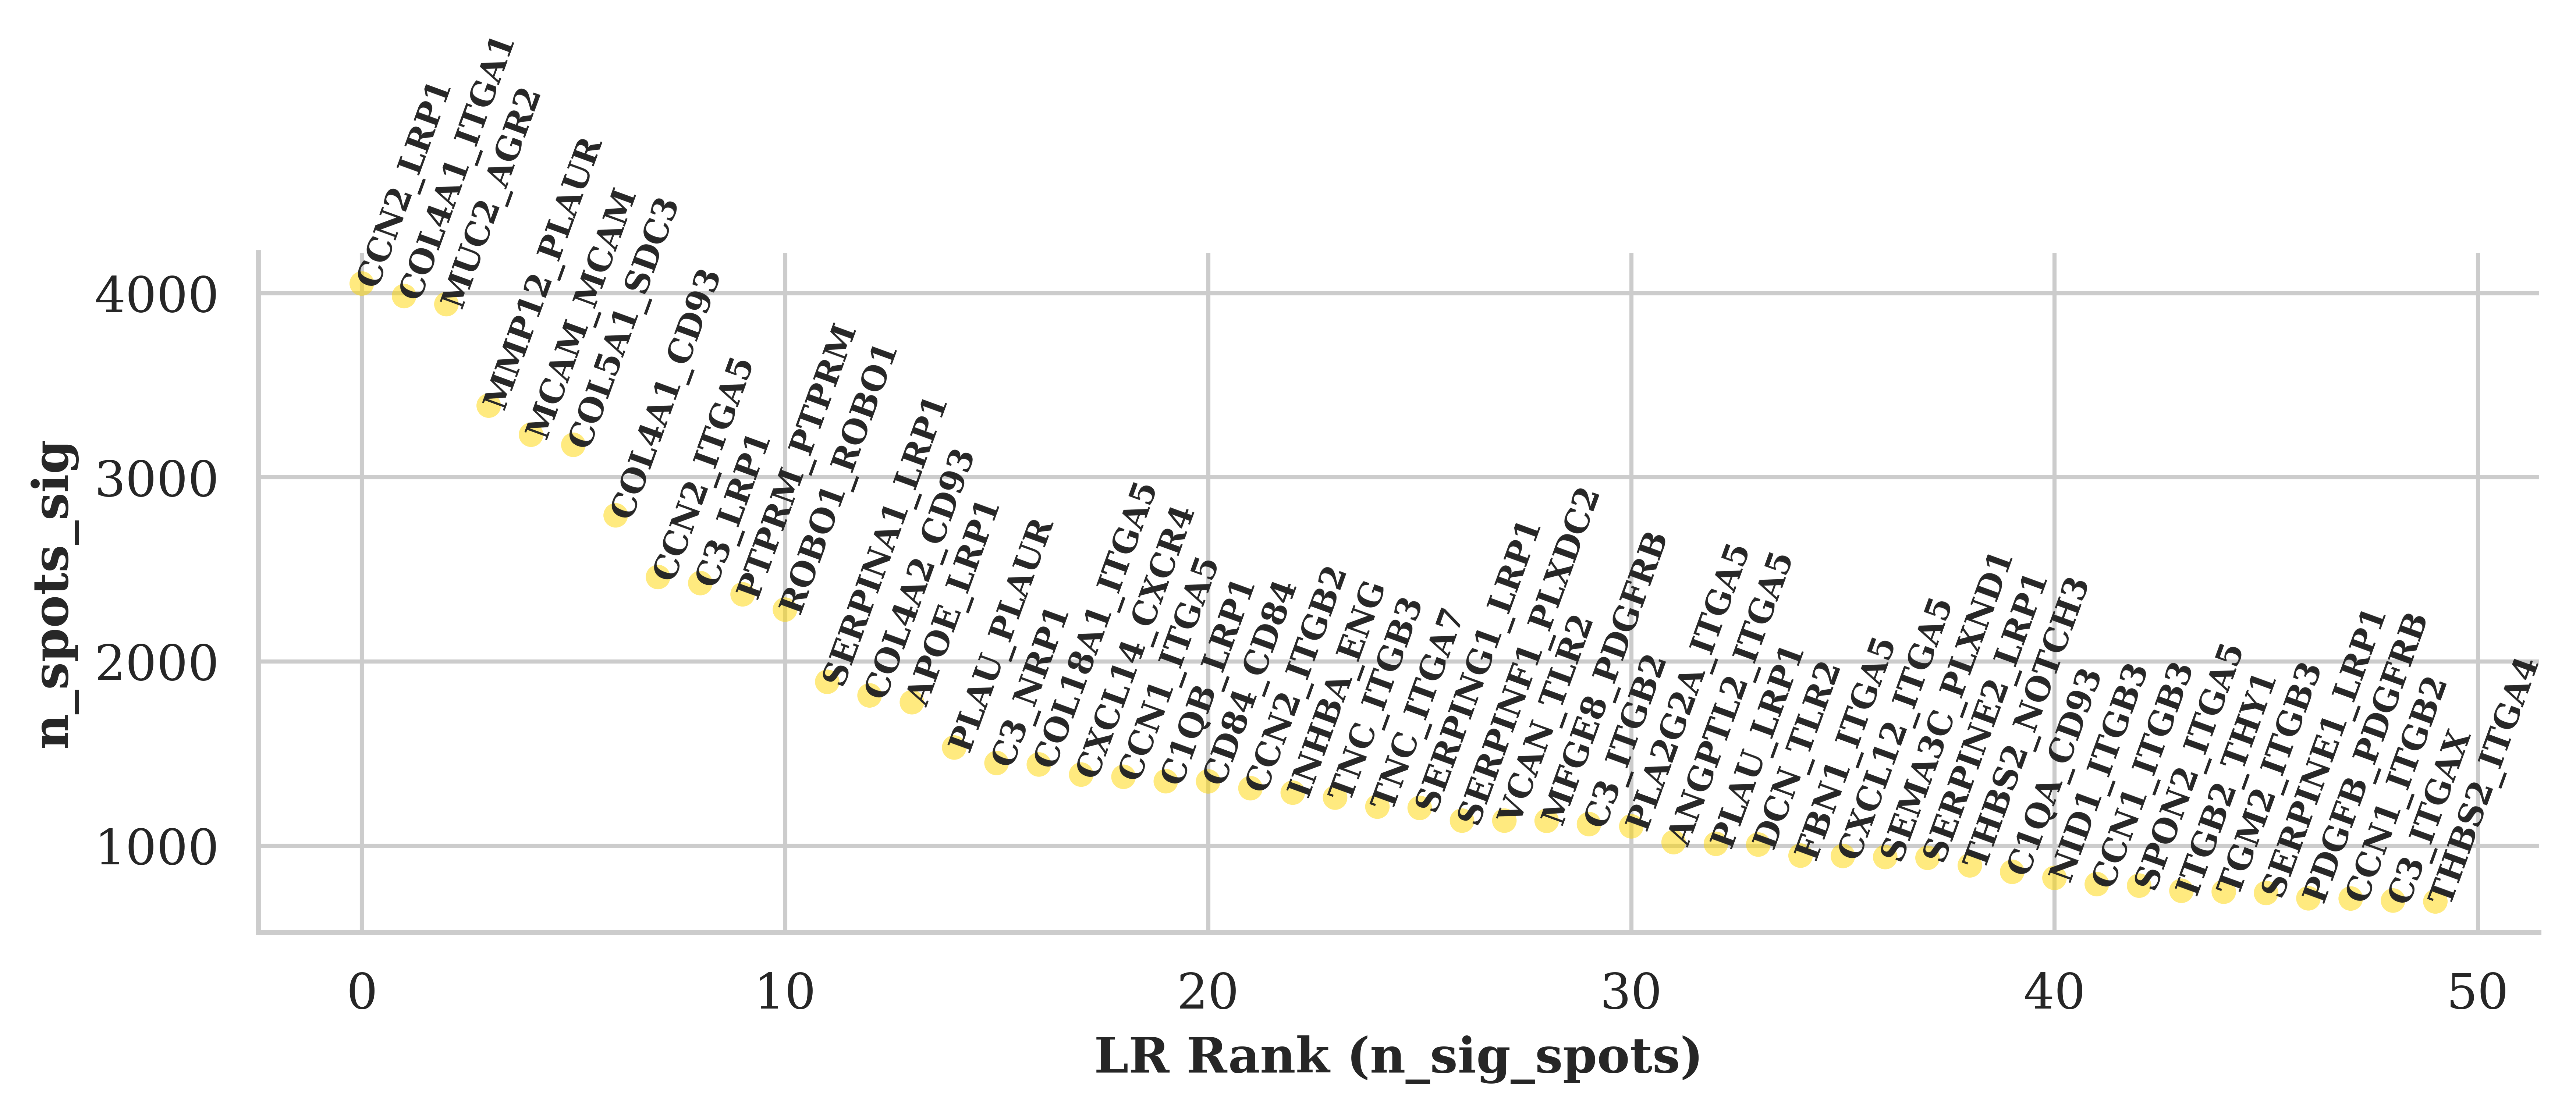

In [15]:
st.pl.lr_summary(andata, n_top=50, figsize=(10,3))

<center>voyagerpy</center>

In this section we will upload the distance and connectivity map results from  rapids-single-cell module. 
One of the big problem is working with sparse matrix from cupyx as alternative to regulate scipy.sparse csr_matrix. 
CuPy sparse matrices to SciPy:
```python
andata.obsp[mat_name] = sparse_matrix_distances.get()
```
SciPy sparse matrices to CuPy:
```python
from cupyx.scipy.sparse import csr_matrix
andata_sub.obsp['distances'] = csr_matrix(andata_sub.obsp['distances'])
andata_sub.obsp['distances'] = csr_matrix(andata_sub.obsp['connectivities'])
```


In [1]:
import cupy as cp
import cupyx
import scanpy as sc
import scanpy as sc
import numpy as np
from cupyx.scipy.sparse import csr_matrix
import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import random
import pandas as pd
import voyagerpy as vp
import geopandas as gpd
import libpysal as lps
from collections import OrderedDict
import scipy.sparse as sp
import pickle

In [2]:
path_016 = "/data/kanferg/Sptial_Omics/playGround/Data/Visium_HD_Human_Colon_Cancer_binned_outputs/binned_outputs/square_016um"
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out_2"
andata = sc.read_h5ad(os.path.join(pathout, "andata_save_colon.h5ad"))
andata.uns['config'] = OrderedDict()
andata.uns['config'] = OrderedDict()
andata.uns["config"]["secondary_var_names"] = andata.var_names
def load_matrix(andata,pathout,npz_file = "obsp_distances.npz",mode = 'sparse', mat_name = 'distances'):
    npzfile = cp.load(os.path.join(pathout, npz_file))
    data = cp.array(npzfile['data'])
    indices = cp.array(npzfile['indices'])
    indptr = cp.array(npzfile['indptr'])
    shape = tuple(npzfile['shape'])
    
    # Reconstruct the sparse matrix
    sparse_matrix_distances = csr_matrix((data, indices, indptr), shape=shape)
    if mode== 'sparse':
        andata.obsp[mat_name] = sparse_matrix_distances
    else:
        andata.obsp[mat_name] = sparse_matrix_distances.get()
    return andata
andata = load_matrix(andata,pathout,npz_file = "obsp_distances_large_colon.npz",mode = 'cupyx', mat_name = 'distances')
andata = load_matrix(andata,pathout,npz_file = "obsp_connectivities_large_colon.npz",mode = 'cupyx', mat_name = 'connectivities')

In [3]:
andata

AnnData object with n_obs × n_vars = 133282 × 1500
    obs: 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'config'
    obsm: 'X_pca', 'spatial'
    layers: 'counts', 'log'
    obsp: 'distances', 'connectivities'

DGE data ```uns.rank_genes_groups```

In [4]:
with open(os.path.join(pathout,"andata_uns_mtracies__colon.pkl"), 'rb') as buff:
    andata_uns_mtracies__colon = pickle.load(buff)
andata.uns['rank_genes_groups'] = andata_uns_mtracies__colon['rank_genes_groups']
del andata_uns_mtracies__colon

LR abnalysis data uns ```andata.uns['lrfeatures']```

In [5]:
with open(os.path.join(pathout,"stlearn_uns_mtracies_colon.pkl"), 'rb') as buff:
    stlearn_uns_mtracies_colon = pickle.load(buff)
andata.uns['lrfeatures'] = stlearn_uns_mtracies_colon['lrfeatures']
andata.uns['lr_summary'] = stlearn_uns_mtracies_colon['lr_summary']
del stlearn_uns_mtracies_colon

LR abnalysis data obsm ```andata.obsm['lr_sig_scores']```

In [6]:
with open(os.path.join(pathout,"stlearn_obsm_mtracies_colon.pkl"), 'rb') as buff:
    stlearn_obsm_mtracies_colon = pickle.load(buff)
andata.obsm['spot_neighbours'] = stlearn_obsm_mtracies_colon['spot_neighbours']
andata.obsm['spot_neigh_bcs'] = stlearn_obsm_mtracies_colon['spot_neigh_bcs']
andata.obsm['lr_scores'] = stlearn_obsm_mtracies_colon['lr_scores']
andata.obsm['p_vals'] = stlearn_obsm_mtracies_colon['spot_neigh_bcs']
andata.obsm['-log10(p_adjs)'] = stlearn_obsm_mtracies_colon['-log10(p_adjs)']
andata.obsm['lr_sig_scores'] = stlearn_obsm_mtracies_colon['lr_sig_scores']
del stlearn_obsm_mtracies_colon

In [7]:
andata

AnnData object with n_obs × n_vars = 133282 × 1500
    obs: 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'config', 'rank_genes_groups', 'lrfeatures', 'lr_summary'
    obsm: 'X_pca', 'spatial', 'spot_neighbours', 'spot_neigh_bcs', 'lr_scores', 'p_vals', '-log10(p_adjs)', 'lr_sig_scores'
    layers: 'counts', 'log'
    obsp: 'distances', 'connectivities'

In [8]:
from scipy.sparse import csr_matrix
andata_sub = andata.copy()
andata_sub.X = csr_matrix(andata_sub.X)
andata_sub = sc.pp.subsample(andata_sub, n_obs=100_000,copy=True)

In [9]:
from cupyx.scipy.sparse import csr_matrix
andata_sub.obsp['distances'] = csr_matrix(andata_sub.obsp['distances'])
andata_sub.obsp['connectivities'] = csr_matrix(andata_sub.obsp['connectivities'])

In [10]:
import scipy.sparse as sp
sparse_dist_matrix = andata_sub.obsp['distances'].tocsr()
sparse_inv_matrix = sparse_dist_matrix.copy()
sparse_inv_matrix.data = 1 / sparse_inv_matrix.data
sparse_inv_matrix.data[sparse_inv_matrix.data == float('inf')] = 0

In [11]:
# Convert the sparse matrix to COOrdinate format
sparse_inv_matrix_coo = sparse_inv_matrix.tocoo()

# Extract the row (focal) and column (neighbor) indices of non-zero entries
focal = sparse_inv_matrix_coo.row
neighbors = sparse_inv_matrix_coo.col

focal = focal.get()
neighbors = neighbors.get() 

idx = np.array(andata_sub.obs_names,dtype=str) # Assuming this is a pandas Index or a list-like structure

# Convert sparse matrix values to a 1D array explicitly
weights = sparse_inv_matrix_coo.data
weights = weights.get()


# Create a DataFrame with focal, neighbor, and weight information
graph_df = pd.DataFrame({
    "focal": idx[focal],
    "neighbor": idx[neighbors],
    "weight": weights  # The actual non-zero values (inverted distances)
})

# Display the DataFrame to check
graph_df.head()

graph_df_filtered = graph_df[graph_df['weight'] != 0]

In [12]:
W = lps.weights.W.from_adjlist(graph_df_filtered)
W.set_transform("r")

In [13]:
knn_graph = "knn_weights"
andata_sub.obsp["knn_weights"] = sparse_inv_matrix.get()

andata_sub.uns.setdefault("spatial", {})
andata_sub.uns["spatial"][knn_graph] = W

In [14]:
qc_features = ["total_counts"]
morans = vp.spatial.moran(andata_sub, qc_features, graph_name=knn_graph)
andata_sub.uns['spatial']['moran'][knn_graph].loc[qc_features, ["I"]]

I
total_counts -0.001476

In [15]:
andata_sub.obsp["knn_weights"]

<100000x100000 sparse matrix of type '<class 'numpy.float32'>'
	with 2750100 stored elements in Compressed Sparse Row format>

In [16]:
andata_sub.obs['total_counts'].values

array([  55., 1108., 5257., ...,  167.,  609.,  564.], dtype=float32)

In [17]:
ylag = lps.weights.lag_spatial(W, andata_sub.obs['total_counts'].values)
andata_sub.obs['lagged_total_counts'] = lps.weights.lag_spatial(W, andata_sub.obs['total_counts'].values)

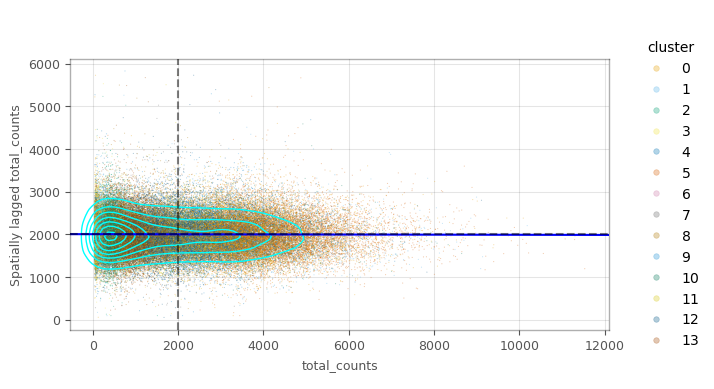

In [25]:
ax = vp.plt.moran_plot(andata_sub, feature="total_counts", color_by='cluster', alpha=0.3,s = 0.1)

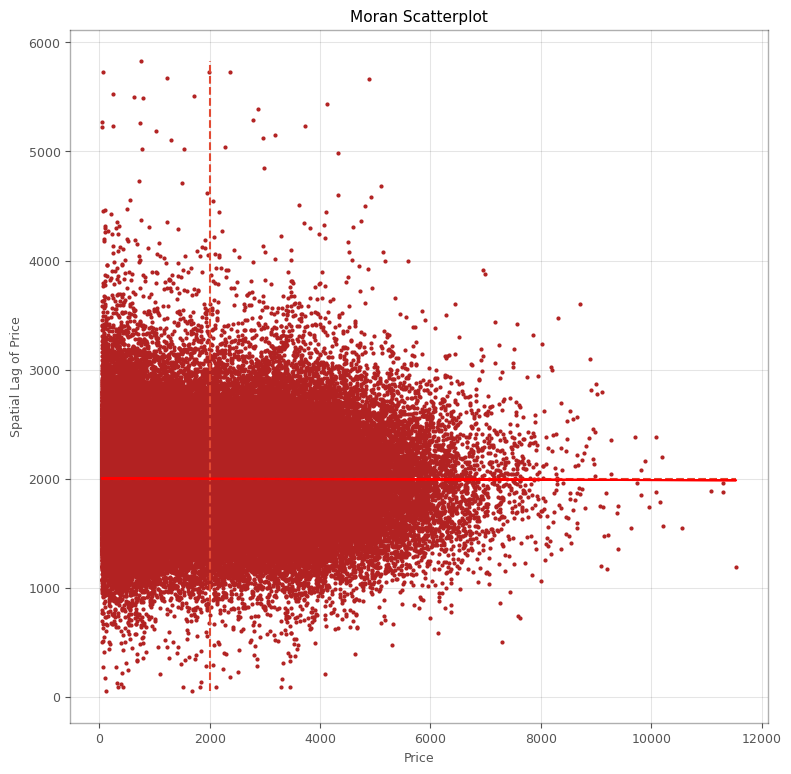

In [26]:
total_count = andata_sub.obs['total_counts'].values
lagged_total_counts = andata_sub.obs['lagged_total_counts'].values
b, a = np.polyfit(total_count, lagged_total_counts, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(total_count, lagged_total_counts, '.', color='firebrick')

 # dashed vert at mean of the price
plt.vlines(total_count.mean(), lagged_total_counts.min(), lagged_total_counts.max(), linestyle='--')
 # dashed horizontal at mean of lagged price
plt.hlines(lagged_total_counts.mean(), total_count.min(), total_count.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(total_count, a + b*total_count, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Price')
plt.xlabel('Price')
plt.show()

In [27]:
_ = vp.spatial.local_moran(andata_sub, qc_features, graph_name=knn_graph)

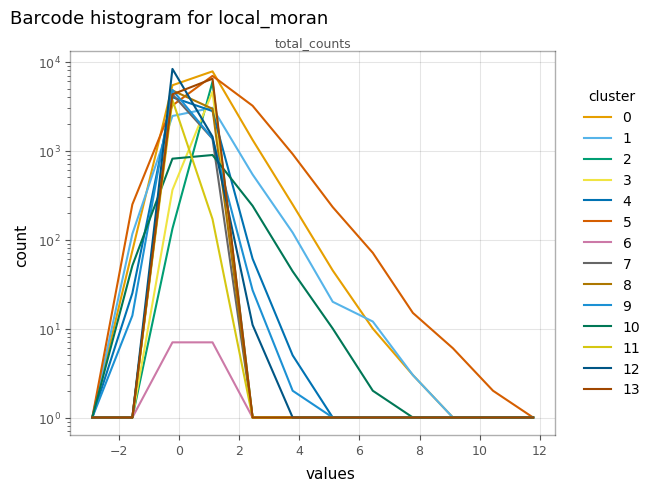

In [28]:
axs = vp.plt.plot_barcode_histogram(
    andata_sub,
    qc_features,
    obsm="local_moran",
    color_by='cluster',
    log=True,
    histtype='line',
    bins=10,
)

In [19]:
andata_sub.obsp['distances']

PairwiseArrays with keys: distances, connectivities, knn_weights

In [24]:
andata_sub.obsp['distances'] = andata_sub.obsp['distances'].get()
andata_sub = sc.pp.subsample(andata_sub, n_obs=7000,copy=True)

In [25]:
hvg = andata_sub.var[andata_sub.var['highly_variable'].values].index

In [26]:
#andata_sub.X = csr_matrix(andata_sub.X)

In [27]:
vp.spatial.moran(andata_sub, feature=hvg, dim='var', graph_name=knn_graph)

ValueError: dimension mismatch

In [69]:
hvgs_moransI = andata_sub.uns['spatial']['moran'][knn_graph].loc[hvg, 'I']
andata_sub.var.loc[hvg, "moran"] = hvgs_moransI

In [71]:
andata_sub.var.loc[hvg, ["moran"]].sort_values(by='moran')

moran
ZCCHC24 -0.008775
JAML    -0.008358
CHST11  -0.008218
RAI14   -0.007994
NES     -0.007983
...           ...
UGT2B7        NaN
PRB3          NaN
CYP19A1       NaN
AHSP          NaN
RS1           NaN

[1500 rows x 1 columns]

In [72]:
andata_sub.var.loc[:, ["moran"]] = np.nan_to_num(andata_sub.var.loc[:, ["moran"]],0.0)
andata_sub.var.loc[hvg, ["moran"]].sort_values(by='moran')

moran
ZCCHC24 -0.008775
JAML    -0.008358
CHST11  -0.008218
RAI14   -0.007994
NES     -0.007983
...           ...
C1QTNF3  0.011142
PGA5     0.012067
PNLIP    0.014767
NRSN1    0.015497
IQCF5    0.021765

[1500 rows x 1 columns]

In [73]:
andata_sub.uns['rank_genes_groups'].keys()

dict_keys(['params', 'names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges'])

In [74]:
pd.DataFrame(andata_sub.uns['rank_genes_groups']['names'])

0       1       2       3       4        5        6       7  \
0       AGR2     PI3     DES   IGHG1  RASSF3      CKB      CKB    PIGR   
1     HMGCS2   CXCL8   MYH11     MGP  CXCL14    CCL20      OMG   FCGBP   
2       PCP4  S100A9   ACTG2   SFRP2    PCP4     PCP4  SLC35G3    MUC2   
3       PLTP   CCL20    MYLK      C3    SPP1      PI3      RS1     CA2   
4       MT1X   PLAUR  SYNPO2  CCDC80   MMP12  CEACAM7    ENDOU  TSPAN1   
...      ...     ...     ...     ...     ...      ...      ...     ...   
1495     LUM   ACTA2    CCN2  TSPAN1     DCN    TIMP2   COL5A1     C1R   
1496   TIMP2   TIMP2    AGR2    AGR2   ACTA2      LUM   COL6A3  COL4A1   
1497  COL5A1     LUM  TSPAN1  CXCL14     LUM      C1R      C1R     LUM   
1498  COL6A3  COL6A3     PI3     PI3   TIMP2   COL5A1   IGFBP4  COL5A1   
1499     C1R  COL5A1  CXCL14     CKB     C1R   COL6A3    IGHG1  COL6A3   

           8        9      10      11      12      13  
0     COL4A1    MMP12    IFI6    PIGR  JCHAIN     LUM  
1     PECAM1   COL4A1     MX1   FCGBP     LYZ   AEBP1  
2        ENG      LYZ   ISG15   OLFM4    C1QC  COL5A1  
3     COL4A2     C1QC   IFIT3    AGR2   IGHG1   THBS2  
4        VWF       F3     PI3    MUC2    LSP1     DCN  
...      ...      ...     ...     ...     ...     ...  
1495    PCP4   TSPAN1   TIMP2  COL6A3  TSPAN1    PCP4  
1496     PI3    GREM1   ACTA2    PLTP    AGR2    AGR2  
1497    AGR2  PLA2G2A  COL5A1    THY1     PI3  TSPAN1  
1498  TSPAN1     PIGR     LUM     MGP    PCP4     PI3  
1499     CKB      DES  COL6A3    PCP4     CKB     CKB  

[1500 rows x 14 columns]

In [61]:
andata_sub.uns['config']['secondary_var_names']

Index(['HES4', 'ISG15', 'MXRA8', 'ANKRD65', 'MMP23B', 'MEGF6', 'SPSB1',
       'PIK3CD', 'ANGPTL7', 'PDPN',
       ...
       'SMIM10', 'FHL1', 'BGN', 'PNCK', 'PDZD4', 'L1CAM', 'DDX3Y', 'UTY',
       'KDM5D', 'EIF1AY'],
      dtype='object', length=1500)

In [ ]:
andata_sub.var.index[adata.var[secondary_column] == genes]

In [75]:
mat_names = np.ravel(pd.DataFrame(andata_sub.uns['rank_genes_groups']['names']).values)

In [76]:
marker_genes = mat_names[:10].tolist()

In [77]:
andata_sub

AnnData object with n_obs × n_vars = 7000 × 1500
    obs: 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'moran'
    uns: 'config', 'clusterColorMap', 'rank_genes_groups', 'pca', 'knn', 'spatial'
    obsm: 'X_pca', 'spatial'
    varm: 'PCs'
    layers: 'counts', 'log'
    obsp: 'knn_distances', 'knn_connectivities', 'knn_weights'

In [79]:
andata_sub.var['symbol'] = andata_sub.var['gene_ids'].values

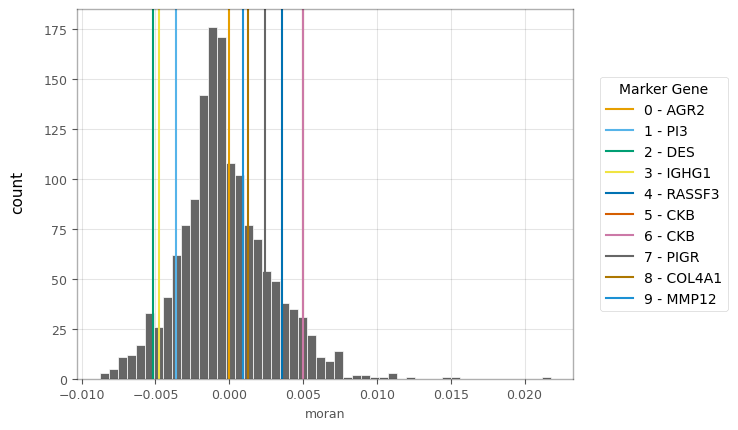

In [81]:
_ = vp.plt.plot_features_histogram(
    andata_sub,
    "moran",
    bins=50,
    log=False,
    histtype="bar",
    markers=marker_genes,
    show_symbol=False
)

In [94]:
cluster_num = len(np.unique(andata_sub.obs['cluster'].values))
cluster_num

13

In [86]:
_ = vp.spatial.local_moran(andata_sub, marker_genes, graph_name=knn_graph)

In [90]:
marker_genes_symbols = andata_sub.var.loc[marker_genes, "symbol"].tolist()
marker_genes_symbols

['ENSG00000106541',
 'ENSG00000124102',
 'ENSG00000175084',
 'ENSG00000211896',
 'ENSG00000153179',
 'ENSG00000166165',
 'ENSG00000166165',
 'ENSG00000162896',
 'ENSG00000187498',
 'ENSG00000262406']

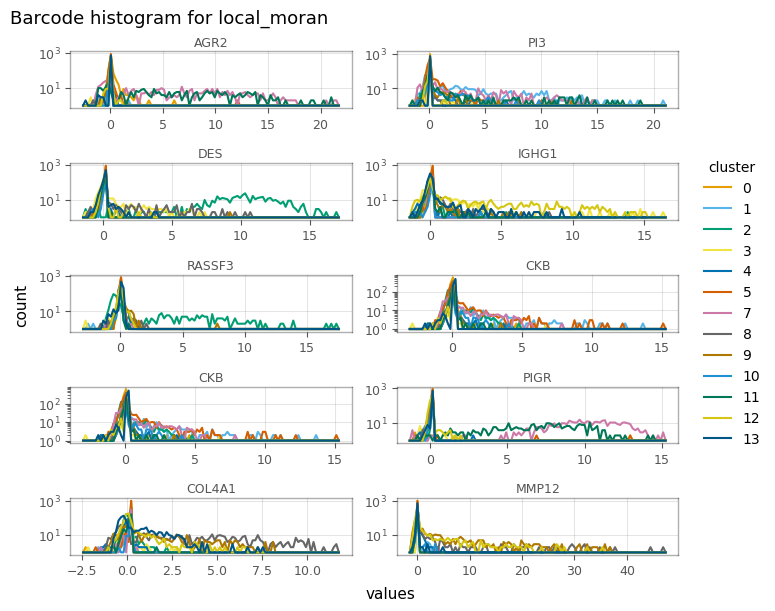

In [93]:
_ = vp.plt.plot_barcode_histogram(
    andata_sub,
    marker_genes,
    color_by='cluster',
    obsm='local_moran',
    histtype='line',
    figsize=(7,6),
    subplot_kwargs=dict(layout='constrained'),
    label=marker_genes,
    ncol=2
)
